In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('../datasets/FE_Final_Data.csv')
print(df.head())
print("\nDataset shape:", df.shape)

print("\nMissing values per column:")
print(df.isnull().sum())

   year  month         state  customers  price     revenue        sales  \
0  2001      1       Wyoming        NaN   4.31    48.12840   1116.17208   
1  2001      1  South Dakota        NaN   5.85    46.98518    803.24177   
2  2001      1     Tennessee        NaN   5.59   539.11548   9648.54559   
3  2001      1         Texas        NaN   6.90  1903.81241  27583.76887   
4  2001      1          Utah        NaN   4.67    95.25759   2039.95489   

  month_name   avg_temp  precipitation  ...  is_high_temp  is_low_temp  \
0    January  22.446063       0.210753  ...         False         True   
1    January  20.430533       0.836671  ...         False         True   
2    January  35.560024       2.914040  ...         False        False   
3    January  47.879498       2.218199  ...         False        False   
4    January  22.953198       0.508612  ...         False         True   

  has_precipitation  is_high_precipitation  has_snowfall  is_heavy_snowfall  \
0              True      

In [5]:
primary_features = [
    'price', 'avg_temp', 'precipitation', 'total_population',
    'season', 'is_summer_peak', 'is_winter_peak',
    'is_high_temp', 'is_low_temp', 'has_precipitation',
    'is_high_precipitation', 'has_snowfall', 'is_heavy_snowfall'
]

In [6]:
# 1. Basic data preparation
def prepare_data(df):
    # Convert season to numeric using one-hot encoding
    season_dummies = pd.get_dummies(df['season'], prefix='season')
    
    # Combine features
    features = df[primary_features].copy()
    features = pd.concat([features, season_dummies], axis=1)
    features.drop('season', axis=1, inplace=True)
    
    # Target variable
    target = df['sales']
    
    return features, target

# 2. Time-based split
def create_time_splits(df, features, target):
    # Training data: 2008-2019
    train_mask = (df['year'] >= 2008) & (df['year'] <= 2019)
    # Validation data: 2020-2021
    val_mask = (df['year'] >= 2020) & (df['year'] <= 2021)
    # Test data: 2022-2023
    test_mask = (df['year'] >= 2022) & (df['year'] <= 2023)
    
    X_train = features[train_mask]
    y_train = target[train_mask]
    X_val = features[val_mask]
    y_val = target[val_mask]
    X_test = features[test_mask]
    y_test = target[test_mask]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [7]:
# Prepare features and target
features, target = prepare_data(df)

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = create_time_splits(df, features, target)

# Check our split sizes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (7200, 16)
Validation set shape: (1200, 16)
Test set shape: (1200, 16)


In [23]:
def create_final_model():
    model = xgb.XGBRegressor(
        n_estimators=200,          # More trees
        learning_rate=0.03,        # Even slower learning
        max_depth=5,               # Slightly deeper trees
        min_child_weight=3,        # Adjusted weight
        subsample=0.9,             # Use 90% of data
        colsample_bytree=0.9,      # Use 90% of features
        reg_alpha=0.1,             # L1 regularization
        reg_lambda=1,              # L2 regularization
        random_state=42,
        eval_metric='rmse'
    )
    return model

# Create and train final model
model_final = create_final_model()
model_final.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=True
)

[0]	validation_0-rmse:5832.25326	validation_1-rmse:6144.48112
[1]	validation_0-rmse:5669.46789	validation_1-rmse:5980.05792
[2]	validation_0-rmse:5512.14974	validation_1-rmse:5822.38115
[3]	validation_0-rmse:5356.45983	validation_1-rmse:5667.85338
[4]	validation_0-rmse:5209.63455	validation_1-rmse:5519.25000
[5]	validation_0-rmse:5066.51159	validation_1-rmse:5376.21169
[6]	validation_0-rmse:5017.92500	validation_1-rmse:5336.47673
[7]	validation_0-rmse:4880.46312	validation_1-rmse:5197.62796
[8]	validation_0-rmse:4834.46443	validation_1-rmse:5162.15083
[9]	validation_0-rmse:4702.29891	validation_1-rmse:5029.42157
[10]	validation_0-rmse:4573.17452	validation_1-rmse:4900.59060
[11]	validation_0-rmse:4447.48529	validation_1-rmse:4775.32214
[12]	validation_0-rmse:4408.35876	validation_1-rmse:4745.41741
[13]	validation_0-rmse:4289.18799	validation_1-rmse:4624.84259
[14]	validation_0-rmse:4172.35278	validation_1-rmse:4508.43118
[15]	validation_0-rmse:4059.65916	validation_1-rmse:4394.98247
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
# Make predictions with improved model
train_pred_improved = model_improved.predict(X_train)
val_pred_improved = model_improved.predict(X_val)
test_pred_improved = model_improved.predict(X_test)

# Calculate performance metrics
print("\nImproved Model Performance:")
print(f"Training RMSE: {root_mean_squared_error(y_train, train_pred_improved):.2f}")
print(f"Validation RMSE: {root_mean_squared_error(y_val, val_pred_improved):.2f}")
print(f"Test RMSE: {root_mean_squared_error(y_test, test_pred_improved):.2f}")

# Feature importance for improved model
importance_improved = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_improved.feature_importances_
})
importance_improved = importance_improved.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features (Improved Model):")
print(importance_improved.head(10))

# Let's also look at some predictions vs actual values
print("\nSample Predictions vs Actual (Test Set):")
comparison = pd.DataFrame({
    'Actual': y_test.head(5),
    'Predicted': test_pred_improved[:5],
    'Difference': abs(y_test.head(5) - test_pred_improved[:5])
})
print(comparison)

ValueError: feature_names mismatch: ['price', 'avg_temp', 'precipitation', 'total_population', 'is_summer_peak', 'is_winter_peak', 'is_high_temp', 'is_low_temp', 'has_precipitation', 'is_high_precipitation', 'has_snowfall', 'is_heavy_snowfall', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter'] ['price', 'avg_temp', 'precipitation', 'total_population', 'is_summer_peak', 'is_winter_peak', 'is_high_temp', 'is_low_temp', 'has_precipitation', 'is_high_precipitation', 'has_snowfall', 'is_heavy_snowfall', 'season_Fall', 'season_Spring', 'season_Summer', 'season_Winter', 'population_group']
training data did not have the following fields: population_group

In [25]:
# Transform target variable
y_train_log = np.log1p(y_train)  # log1p preserves zero values
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

def create_log_model():
    model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.03,
        max_depth=5,
        min_child_weight=3,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        eval_metric='rmse'
    )
    return model

# Train model on log-transformed data
model_log = create_log_model()
model_log.fit(
    X_train,
    y_train_log,
    eval_set=[(X_train, y_train_log), (X_val, y_val_log)],
    verbose=True
)

# Make predictions and transform back
train_pred_log = np.expm1(model_log.predict(X_train))
val_pred_log = np.expm1(model_log.predict(X_val))
test_pred_log = np.expm1(model_log.predict(X_test))

[0]	validation_0-rmse:0.98266	validation_1-rmse:0.98030
[1]	validation_0-rmse:0.95451	validation_1-rmse:0.95218
[2]	validation_0-rmse:0.92725	validation_1-rmse:0.92495
[3]	validation_0-rmse:0.90103	validation_1-rmse:0.89888
[4]	validation_0-rmse:0.87550	validation_1-rmse:0.87334
[5]	validation_0-rmse:0.85068	validation_1-rmse:0.84859
[6]	validation_0-rmse:0.84126	validation_1-rmse:0.83905
[7]	validation_0-rmse:0.81749	validation_1-rmse:0.81528
[8]	validation_0-rmse:0.80848	validation_1-rmse:0.80645
[9]	validation_0-rmse:0.78577	validation_1-rmse:0.78376
[10]	validation_0-rmse:0.76365	validation_1-rmse:0.76175
[11]	validation_0-rmse:0.74235	validation_1-rmse:0.74048
[12]	validation_0-rmse:0.73457	validation_1-rmse:0.73272
[13]	validation_0-rmse:0.71402	validation_1-rmse:0.71215
[14]	validation_0-rmse:0.69408	validation_1-rmse:0.69225
[15]	validation_0-rmse:0.67475	validation_1-rmse:0.67292
[16]	validation_0-rmse:0.65598	validation_1-rmse:0.65423
[17]	validation_0-rmse:0.64935	validation

In [26]:
# Calculate performance metrics on original scale
print("\nModel Performance (Original Scale):")
print(f"Training RMSE: {root_mean_squared_error(y_train, train_pred_log):.2f}")
print(f"Validation RMSE: {root_mean_squared_error(y_val, val_pred_log):.2f}")
print(f"Test RMSE: {root_mean_squared_error(y_test, test_pred_log):.2f}")

# Look at predictions vs actuals
print("\nSample Predictions vs Actual (Test Set):")
comparison_log = pd.DataFrame({
    'Actual': y_test.head(5),
    'Predicted': test_pred_log[:5],
    'Percentage_Error': abs(y_test.head(5) - test_pred_log[:5]) / y_test.head(5) * 100
})
print(comparison_log)

# Feature importance
importance_log = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model_log.feature_importances_
})
importance_log = importance_log.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(importance_log.head(10))


Model Performance (Original Scale):
Training RMSE: 687.07
Validation RMSE: 1067.21
Test RMSE: 2509.23

Sample Predictions vs Actual (Test Set):
            Actual    Predicted  Percentage_Error
12600    533.71382   507.875061          4.841313
12601  12236.02090  8886.961914         27.370491
12602   9125.68871  8971.709961          1.687311
12603   3334.00196  3095.881104          7.142193
12604   6248.51212  5527.901367         11.532517

Top 10 Most Important Features:
                  feature  importance
3        total_population    0.477916
0                   price    0.145271
6            is_high_temp    0.108582
15          season_Winter    0.073413
2           precipitation    0.061144
14          season_Summer    0.032084
9   is_high_precipitation    0.029403
1                avg_temp    0.023663
5          is_winter_peak    0.011956
7             is_low_temp    0.009524


In [27]:
# 1. First, create population groups
X_train['population_group'] = pd.qcut(X_train['total_population'], 
                                    q=3, 
                                    labels=['small', 'medium', 'large'])

# 2. Let's see how many states in each group
print("States in each population group:")
print(X_train['population_group'].value_counts())

# 3. Let's see average sales for each group
print("\nAverage sales by population group:")
for group in ['small', 'medium', 'large']:
    mask = X_train['population_group'] == group
    avg_sales = y_train[mask].mean()
    print(f"{group} population states: {avg_sales:.2f}")

States in each population group:
population_group
small     2448
medium    2448
large     2304
Name: count, dtype: int64

Average sales by population group:
small population states: 1571.69
medium population states: 5460.07
large population states: 11972.68


C:\Users\Ahmed Ayaz\AppData\Local\Temp\ipykernel_30236\2349836470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['population_group'] = pd.qcut(X_train['total_population'],


In [29]:
# First, let's create a function to add population groups
def add_population_groups(data):
    data = data.copy()
    data['population_group'] = pd.qcut(data['total_population'], 
                                     q=3, 
                                     labels=['small', 'medium', 'large'])
    return data

# Add population groups to all our datasets
X_train = add_population_groups(X_train)
X_val = add_population_groups(X_val)
X_test = add_population_groups(X_test)

# Now let's create our models
def create_stratified_models():
    models = {}
    
    for group in ['small', 'medium', 'large']:
        print(f"\nTraining model for {group} population states...")
        
        # Get data for this group
        mask = X_train['population_group'] == group
        X_group = X_train[mask].drop(['population_group'], axis=1)
        y_group = y_train[mask]
        
        # Create and train model
        model = xgb.XGBRegressor(
            n_estimators=100,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='rmse'
        )
        
        # Train the model
        model.fit(X_group, y_group, verbose=False)
        models[group] = model
    
    return models

# Train our models
stratified_models = create_stratified_models()

# Make predictions for each group
print("\nModel Performance by Group:")
for group in ['small', 'medium', 'large']:
    # Training performance
    train_mask = X_train['population_group'] == group
    X_group_train = X_train[train_mask].drop(['population_group'], axis=1)
    train_pred = stratified_models[group].predict(X_group_train)
    train_rmse = root_mean_squared_error(y_train[train_mask], train_pred)
    
    # Test performance
    test_mask = X_test['population_group'] == group
    X_group_test = X_test[test_mask].drop(['population_group'], axis=1)
    test_pred = stratified_models[group].predict(X_group_test)
    test_rmse = root_mean_squared_error(y_test[test_mask], test_pred)
    
    print(f"\n{group.capitalize()} Population States:")
    print(f"Training RMSE: {train_rmse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    
    # Show sample predictions
    print(f"\nSample predictions for {group} states:")
    sample_df = pd.DataFrame({
        'Actual': y_test[test_mask][:3],
        'Predicted': test_pred[:3],
        'Error%': abs(y_test[test_mask][:3] - test_pred[:3]) / y_test[test_mask][:3] * 100
    })
    print(sample_df)


Training model for small population states...

Training model for medium population states...

Training model for large population states...

Model Performance by Group:

Small Population States:
Training RMSE: 135.47
Test RMSE: 421.61

Sample predictions for small states:
           Actual    Predicted     Error%
12600   533.71382   503.645172   5.633852
12603  3334.00196  2951.992432  11.457988
12608   639.09050   691.410400   8.186618

Medium Population States:
Training RMSE: 391.70
Test RMSE: 653.88

Sample predictions for medium states:
           Actual    Predicted     Error%
12604  6248.51212  5729.007812   8.314048
12605  5745.39220  4226.968262  26.428552
12606  5192.93620  4506.445801  13.219696

Large Population States:
Training RMSE: 899.94
Test RMSE: 3723.71

Sample predictions for large states:
            Actual     Predicted     Error%
12601  12236.02090   8880.142578  27.426223
12602   9125.68871   8854.101562   2.976073
12607  14002.14798  13055.244141   6.762561


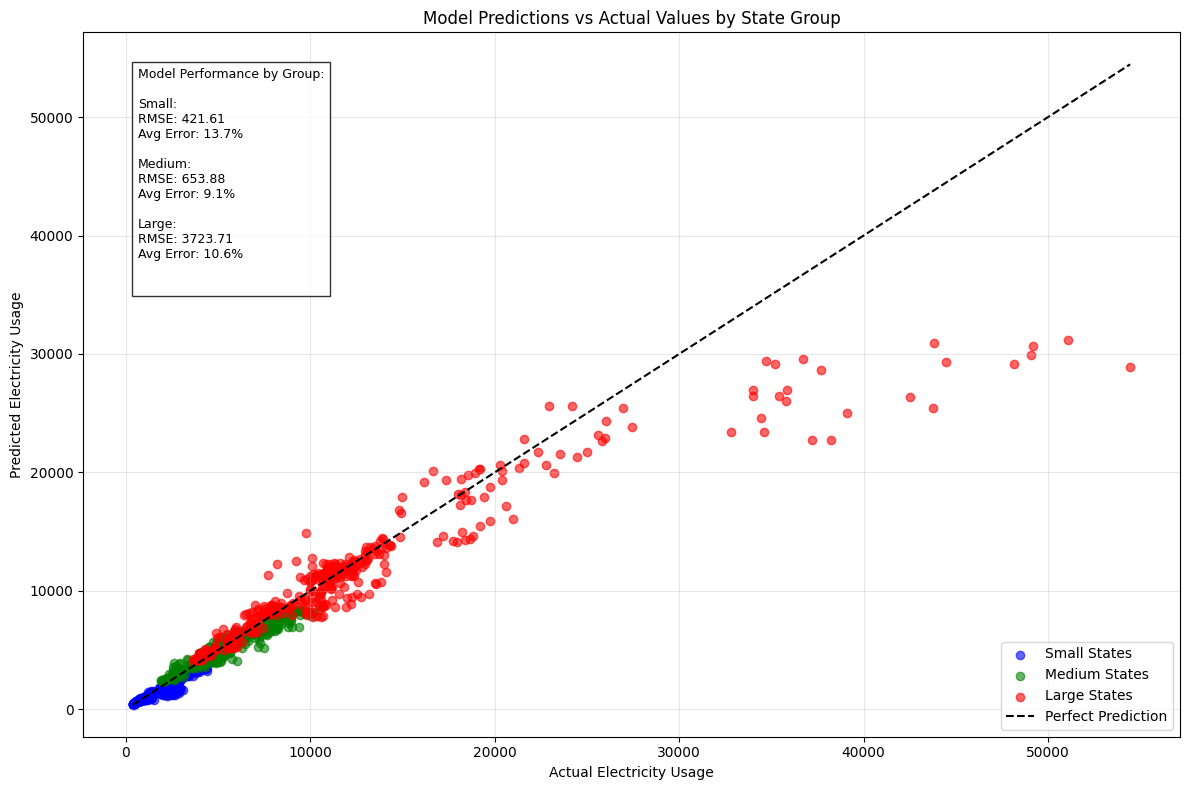

In [47]:
# Let's make fresh predictions with our stratified models
def make_predictions_for_all():
    predictions = []
    
    # Make predictions for each group
    for group in ['small', 'medium', 'large']:
        mask = X_test['population_group'] == group
        X_group = X_test[mask].drop('population_group', axis=1)
        
        # Make predictions for this group
        group_predictions = stratified_models[group].predict(X_group)
        
        # Store predictions with their indices to maintain order
        for idx, pred in zip(X_group.index, group_predictions):
            predictions.append((idx, pred))
    
    # Sort by original index and get just predictions
    predictions.sort(key=lambda x: x[0])
    return [p[1] for p in predictions]

# Make new predictions
new_test_pred = make_predictions_for_all()


def create_complete_performance_plot():
    plt.figure(figsize=(12, 8))
    
    # Plot each group with different colors
    colors = {'small': 'blue', 'medium': 'green', 'large': 'red'}
    
    # Store errors for text display
    error_stats = {}
    
    for group in ['small', 'medium', 'large']:
        mask = X_test['population_group'] == group
        actuals = y_test[mask]
        predictions = np.array(new_test_pred)[mask]
        
        # Calculate RMSE
        rmse = root_mean_squared_error(actuals, predictions)
        
        # Calculate percentage errors
        percent_errors = abs((predictions - actuals) / actuals) * 100
        avg_percent_error = np.mean(percent_errors)
        
        error_stats[group] = {
            'rmse': rmse,
            'avg_percent_error': avg_percent_error
        }
        
        plt.scatter(actuals, predictions, 
                   alpha=0.6, 
                   color=colors[group],
                   label=f'{group.capitalize()} States')
    
    # Add perfect prediction line
    all_vals = np.concatenate([y_test, new_test_pred])
    max_val = np.max(all_vals)
    min_val = np.min(all_vals)
    plt.plot([min_val, max_val], [min_val, max_val], 
             'k--', label='Perfect Prediction')
    
    plt.xlabel('Actual Electricity Usage')
    plt.ylabel('Predicted Electricity Usage')
    plt.title('Model Predictions vs Actual Values by State Group')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Create detailed error text
    error_text = "Model Performance by Group:\n\n"
    for group in ['small', 'medium', 'large']:
        error_text += f"{group.capitalize()}:\n"
        error_text += f"RMSE: {error_stats[group]['rmse']:.2f}\n"
        error_text += f"Avg Error: {error_stats[group]['avg_percent_error']:.1f}%\n\n"
    
    plt.text(0.05, 0.95, error_text, 
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.8),
             verticalalignment='top',
             fontsize=9)
    
    plt.tight_layout()
    plt.show()

# Create the plot
create_complete_performance_plot()

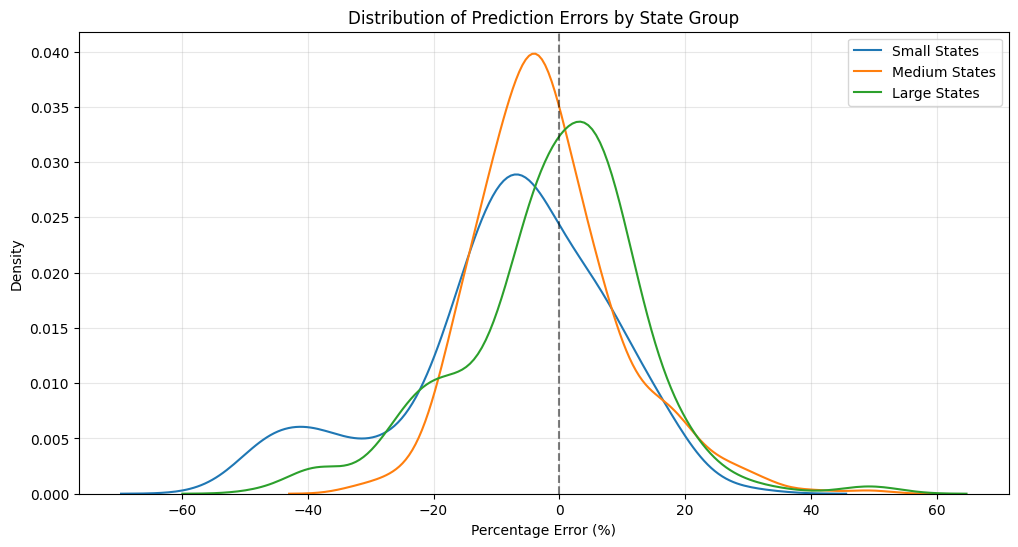

In [37]:
def plot_error_distribution():
    plt.figure(figsize=(12, 6))
    
    for group in ['small', 'medium', 'large']:
        mask = X_test['population_group'] == group
        actuals = y_test[mask]
        predictions = np.array(new_test_pred)[mask]
        
        # Calculate percentage errors
        errors = ((predictions - actuals) / actuals) * 100
        
        # Create density plot
        sns.kdeplot(data=errors, label=f'{group.capitalize()} States')
    
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Percentage Error (%)')
    plt.ylabel('Density')
    plt.title('Distribution of Prediction Errors by State Group')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Create the plot
plot_error_distribution()

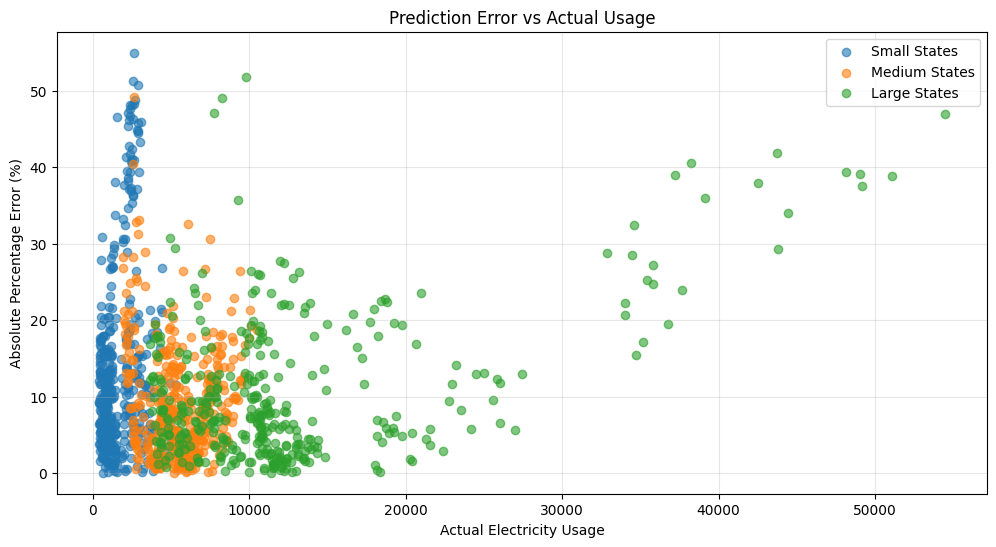

In [38]:
def plot_error_by_size():
    plt.figure(figsize=(12, 6))
    
    for group in ['small', 'medium', 'large']:
        mask = X_test['population_group'] == group
        actuals = y_test[mask]
        predictions = np.array(new_test_pred)[mask]
        
        # Calculate absolute percentage errors
        errors = abs((predictions - actuals) / actuals) * 100
        
        plt.scatter(actuals, errors, 
                   alpha=0.6, 
                   label=f'{group.capitalize()} States')
    
    plt.xlabel('Actual Electricity Usage')
    plt.ylabel('Absolute Percentage Error (%)')
    plt.title('Prediction Error vs Actual Usage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Create the plot
plot_error_by_size()

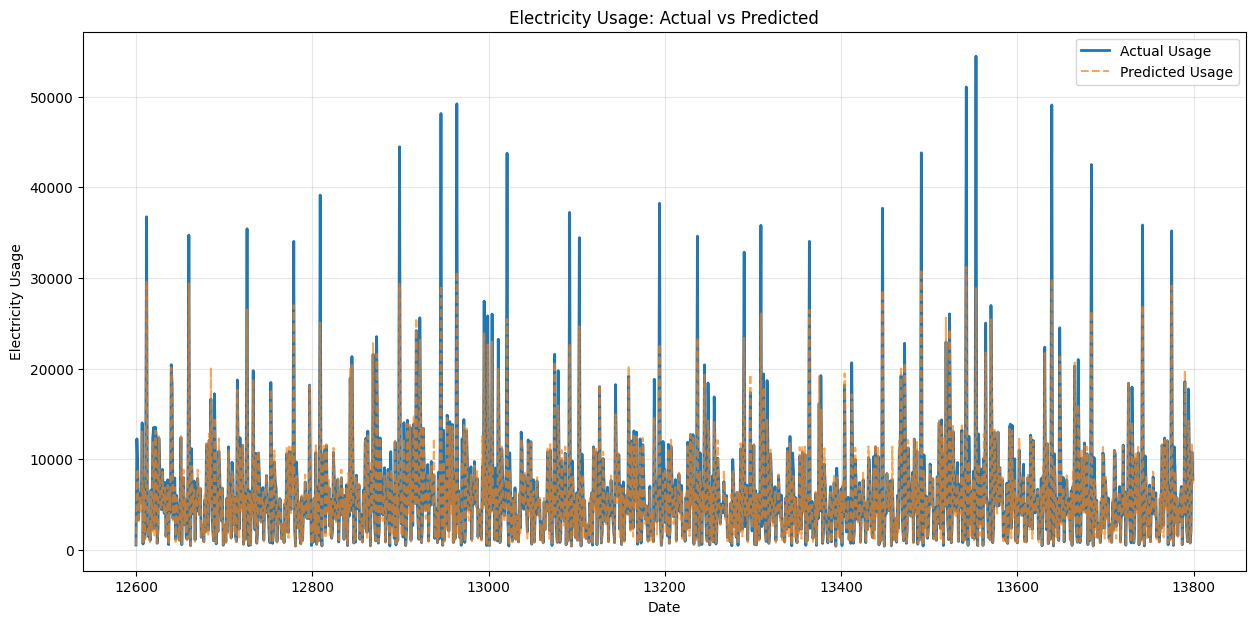

In [40]:
def plot_predictions_over_time():
    plt.figure(figsize=(15, 7))
    
    # Plot actual values and predictions
    plt.plot(X_test.index, y_test, 
            label='Actual Usage', 
            linewidth=2)
    plt.plot(X_test.index, new_test_pred, 
            label='Predicted Usage', 
            linestyle='--', 
            alpha=0.7)
    
    plt.title('Electricity Usage: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Electricity Usage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

plot_predictions_over_time()

In [46]:
def plot_predictions_over_time():
    # Create datetime index
    dates = pd.to_datetime(X_test['year'].astype(str) + '-' + X_test['month'].astype(str) + '-01')
    
    plt.figure(figsize=(15, 7))
    
    # Plot with proper dates
    plt.plot(dates, y_test, 
            label='Actual Usage', 
            linewidth=2,
            color='blue')
    plt.plot(dates, new_test_pred, 
            label='Predicted Usage', 
            linestyle='--', 
            color='orange',
            alpha=0.7)
    
    plt.title('Electricity Usage: Actual vs Predicted (2022-2023)')
    plt.xlabel('Date')
    plt.ylabel('Electricity Usage')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Format date axis
    plt.gcf().autofmt_xdate()  # Angle and align the tick labels
    
    # Add gridlines and formatting
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Show every 2 months
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format as 'Jan 2022'
    
    plt.tight_layout()
    plt.show()

# Create the plot
plot_predictions_over_time()

KeyError: 'year'